In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from statistics import mean
from scipy.optimize import curve_fit
import scipy
import sys

sys.path.insert(0, './NUC')
from NUC_functions import create_NUC_df, collapse_df,compile_NUC_matrix_input,calc_NUC_coef

In [2]:
tpath = '/Volumes/KESU/chamber_data/TemperatureData/'
path = '/Volumes/KESU/chamber_data/'

In [143]:
filename = '02171524.TXT'
data = pd.read_csv(tpath+filename,header = 0,delimiter= '\s+')

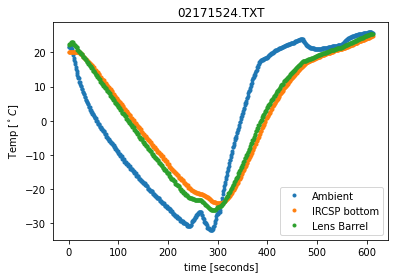

In [144]:
plt.plot(data['1ch'],'.',label = 'Ambient')
plt.plot(data['2ch'],'.',label = 'IRCSP bottom')
plt.plot(data['3ch'],'.', label = 'Lens Barrel')
plt.ylabel('Temp [$^\circ C$]')
plt.xlabel('time [seconds]')
plt.title(filename)
plt.legend()
plt.show()

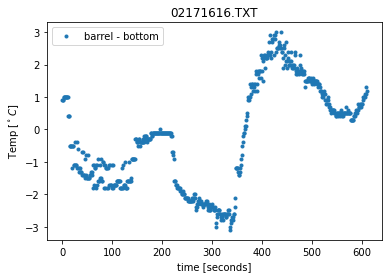

In [133]:

plt.plot(data['3ch']-data['2ch'],'.',label = 'barrel - bottom')
plt.ylabel('Temp [$^\circ C$]')
plt.xlabel('time [seconds]')
plt.title(filename)
plt.legend()
plt.show()

In [6]:
h5name = 'Center_0mm_neg0c.h5'
df1 = create_NUC_df(path, h5name)

In [7]:
df2 = create_NUC_df(path, 'Center_0mm_neg0c-2.h5')

In [193]:
h5name = 'Right_0mm_neg0c-2.h5'

In [194]:
df = create_NUC_df(path, h5name) #pd.concat([df1,df2],ignore_index=True)


In [195]:
'''fix wrapping error'''
def correct_temps(df,key):
    for i in range(len(df[key])):
        if df[key][i] > 100:
            t1 = df[key][i]
            t2 =t1-6553.5
            df[key][i] = t2

In [196]:
correct_temps(df, "temps1")
correct_temps(df, "temps2")

ValueError: x and y must have same first dimension, but have shapes (1000,) and (200,)

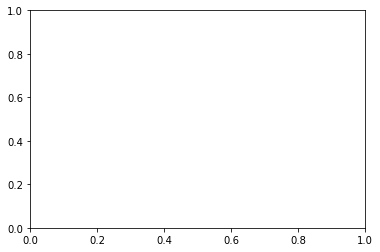

In [180]:
plt.plot(c_times,df['temps1'],'.r', label = 'camera1 FPA')
plt.plot(c_times,df['temps2'],'.b',label = 'camera2 FPA')
plt.ylabel('Temp [$^\circ C$]')
plt.xlabel('time [minutes]')
plt.title('FPA temperature over time')
plt.legend()
plt.show()

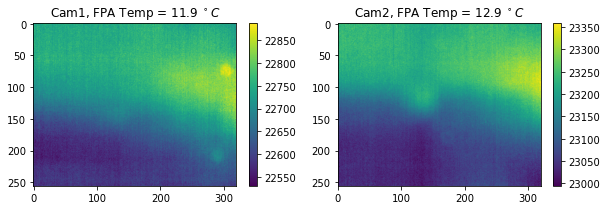

In [197]:
index = 100

#active area
ymin1 = 105; ymax1 = 140;
ymin2 = 130; ymax2 = 165;

# generate randomly populated arrays
data1 = df['imgs1'][index]#[ymin2:ymax2,100:150]
data2 = df['imgs2'][index]#[ymin1:ymax1,100:150]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,3)) # 2 axes on a 1x2 grid

# nir in first subplot
nir = ax1.imshow(data1)
ax1.set_title("Cam1, FPA Temp = " + str(np.round(df['temps1'][index],2)) + ' $^\circ C$')
fig.colorbar(nir, ax=ax1)

# Now red band in the second subplot
red = ax2.imshow(data2)
ax2.set_title("Cam2, FPA Temp = " + str(np.round(df['temps2'][index],2)) + ' $^\circ C$')
fig.colorbar(red, ax=ax2)

plt.show()

In [73]:
r1 = []
r2 = []
r11=[]
r22=[]
for i in range(len(df["imgs1"])):
    c1 = np.mean(df['imgs1'][i][ymin2:ymax2,100:150])
    c2 = np.mean(df['imgs2'][i][ymin1:ymax1,100:150])
    c11 = np.mean(df['imgs1'][i][200:249,0:50])
    c22 = np.mean(df['imgs2'][i][200:249,0:50])
    r1.append(c1)
    r2.append(c2)
    r11.append(c11)
    r22.append(c22)

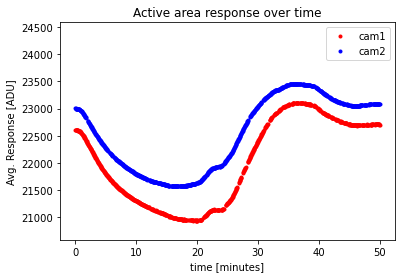

In [161]:
plt.plot(c_times,r1,'.r',label = 'cam1')
plt.plot(c_times,r2,'.b',label = 'cam2')
plt.ylim(r1[10]-2000,r1[10]+2000)
plt.ylabel('Avg. Response [ADU]')
plt.xlabel('time [minutes]')
plt.title('Active area response over time')
plt.legend()
plt.show()

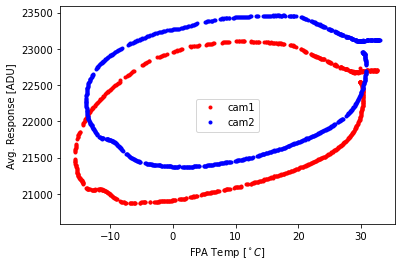

In [162]:
plt.plot(df['temps1'],r11,'. r',label = 'cam1')
plt.plot(df['temps2'],r22,'. b',label = 'cam2')
plt.ylim(r1[10]-2000,r1[10]+1000)
plt.xlabel('FPA Temp [$^\circ C$]')
plt.ylabel('Avg. Response [ADU]')
plt.legend()
plt.show()

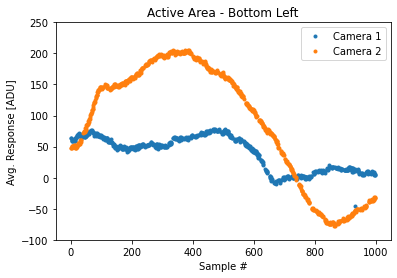

In [76]:
plt.plot(np.array(r1)-np.array(r11),'.',label = 'Camera 1')
plt.plot(np.array(r2)-np.array(r22),'.',label = 'Camera 2')
plt.ylabel('Avg. Response [ADU]')
plt.xlabel('Sample #')
plt.title("Active Area - Bottom Left")
plt.ylim(-100,250)
plt.legend()
plt.show()

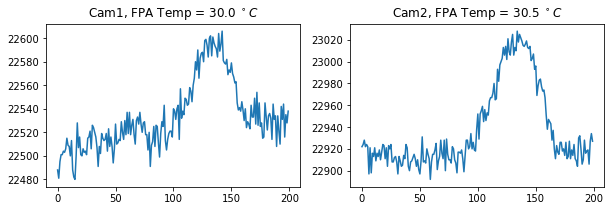

In [77]:
index = 10

#active area
ymin1 = 105; ymax1 = 140;
ymin2 = 130; ymax2 = 165;

# generate randomly populated arrays
data1 = df['imgs1'][index][ymin2:ymax2,0:200]
data2 = df['imgs2'][index][ymin1:ymax1,0:200]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,3)) # 2 axes on a 1x2 grid

# nir in first subplot
nir = ax1.plot(data1[2])
ax1.set_title("Cam1, FPA Temp = " + str(np.round(df['temps1'][index],2)) + ' $^\circ C$')
#fig.colorbar(nir, ax=ax1)

# Now red band in the second subplot
red = ax2.plot(data2[2])
ax2.set_title("Cam2, FPA Temp = " + str(np.round(df['temps2'][index],2)) + ' $^\circ C$')
#fig.colorbar(red, ax=ax2)

plt.show()

In [150]:
'''need to associate chamber measurements with FPA

FPA triggered every 3 seconds, 1000 total
chamber thermisters go once every 5 and have longer duration'''

camera_time = 1000 *3 /60 #minutes
camera_save = 14 #get this from file
if (camera_save-camera_time) < 0:
    camera_start = 60 + camera_save - camera_time
else:
    camera_start = camera_save-camera_time

# make string of chamber thermiseter times
s = data['time'][0]
hours, minutes,seconds = map(int, s.split(':'))
temp_start = minutes

t_times = np.arange(0,((len(data['time']))*5)/60-1/60,5/60) # in minutes

if camera_start > minutes:
    start = minutes - camera_start
else:
    start = 0
    
c_times = np.arange(start,((len(df['temps1']))*3)/60 -1/60,3/60) # in minutes    

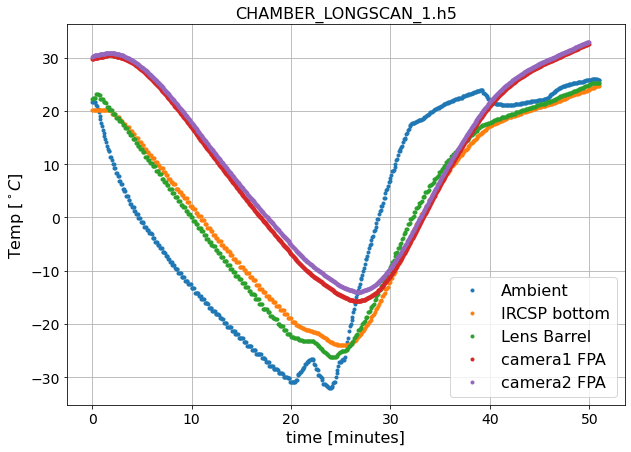

<Figure size 1440x720 with 0 Axes>

In [151]:
f = plt.figure() 
f.set_figwidth(10) 
f.set_figheight(7) 
  

plt.plot(t_times,data['1ch'],'.',label = 'Ambient')
plt.plot(t_times,data['2ch'],'.',label = 'IRCSP bottom')
plt.plot(t_times,data['3ch'],'.', label = 'Lens Barrel')
plt.plot(c_times,df['temps1'],'.', label = 'camera1 FPA')
plt.plot(c_times,df['temps2'],'.',label = 'camera2 FPA')
plt.ylabel('Temp [$^\circ C$]',fontsize =16)
plt.xlabel('time [minutes]',fontsize =16)
plt.title(h5name,fontsize =16)
plt.legend(fontsize = 16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.figure(figsize=(20,10)) 
plt.show()

In [141]:
np.array(df['temps1'])

array([ 34.2,  34.2,  34.2,  34.3,  34.3,  34.3,  34.4,  34.4,  34.4,
        34.5,  34.5,  34.5,  34.5,  34.6,  34.6,  34.6,  34.7,  34.7,
        34.7,  34.7,  34.8,  34.8,  34.8,  34.8,  34.8,  34.8,  34.9,
        34.9,  34.9,  34.9,  34.9,  34.9,  34.9,  34.9,  34.9,  34.9,
        34.9,  34.9,  34.9,  34.9,  34.9,  34.9,  34.9,  34.9,  34.8,
        34.8,  34.8,  34.8,  34.8,  34.7,  34.7,  34.7,  34.6,  34.6,
        34.6,  34.5,  34.5,  34.5,  34.4,  34.4,  34.3,  34.3,  34.2,
        34.2,  34.1,  34.1,  34. ,  34. ,  33.9,  33.8,  33.8,  33.7,
        33.7,  33.6,  33.5,  33.5,  33.4,  33.3,  33.2,  33.2,  33.1,
        33. ,  33. ,  32.9,  32.8,  32.7,  32.6,  32.6,  32.5,  32.4,
        32.3,  32.2,  32.1,  32. ,  32. ,  31.9,  31.8,  31.7,  31.6,
        31.5,  31.4,  31.3,  31.3,  31.2,  31.1,  31. ,  30.9,  30.8,
        30.7,  30.6,  30.5,  30.4,  30.3,  30.2,  30.1,  30. ,  29.9,
        29.8,  29.7,  29.6,  29.5,  29.4,  29.2,  29.1,  29. ,  28.9,
        28.8,  28.7,

In [152]:
name = 'scan1'
#create hdf5 file  
hf = h5py.File(path + name + '.h5', 'w')
hf.create_dataset('FPA_times_minutes',        data=c_times)
hf.create_dataset('thermister_times_minutes', data=t_times)
hf.create_dataset('FPA1',                     data=np.array(df['temps1']))
hf.create_dataset('FPA2',                     data=np.array(df['temps2']))
hf.create_dataset('ambient',                  data=np.array(data['1ch']))
hf.create_dataset('lens',                     data=np.array(data['3ch']))
hf.create_dataset('IRCSP_bottom',             data=np.array(data['2ch']))
hf.close()